# PLOT 1: num_samples = 100

Saved DoLP residuals to Hamal_DoLP_residuals_noise_0.1_sub_tint_1.npy
Saved integration times to Hamal_integration_times_noise_0.1_sub_tint_1.npy
Saved DoLP residuals to Mirfak_DoLP_residuals_noise_0.1_sub_tint_1.npy
Saved integration times to Mirfak_integration_times_noise_0.1_sub_tint_1.npy
Saved DoLP residuals to Polaris_DoLP_residuals_noise_0.1_sub_tint_1.npy
Saved integration times to Polaris_integration_times_noise_0.1_sub_tint_1.npy


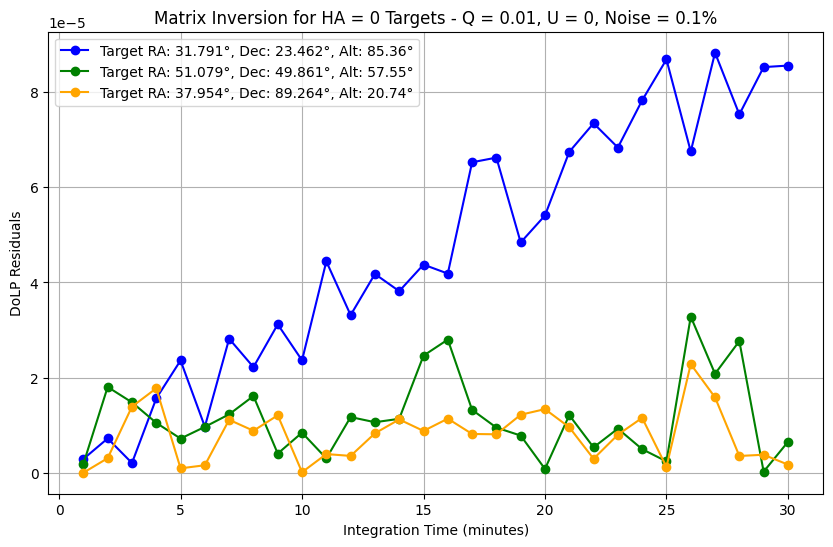

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm
import stokes

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Time intervals in seconds (1 to 10 minutes in 1-minute increments)
sub_tint = 1  # Sub-integration time in seconds
sampled_steps = 100
time_intervals = np.arange(1, 31) * 60  # Convert minutes to seconds
Q_injected = 0.01  # Example injected polarization level in Stokes Q
U_injected = 0
noise_percentage = 0.1

# Colors for each target
colors = ['blue', 'green', 'orange']

# Plot data storage
polarization_differences = {i: [] for i in range(len(targets))}

# Run the simulation for each target and each time interval
for target_idx, target in enumerate(targets):
    injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
    
    for t_int in time_intervals:
        # Run matrix inversion function with dynamic PA and altitude, using sub_tint = 1 second
        S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
            ra=target["ra"], 
            dec=target["dec"], 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude, 
            jd_str=observation_date, 
            ut_start=observation_time, 
            t_int=t_int, 
            Q=Q_injected, 
            U=U_injected, 
            delta_HWP=0.5,
            noise_percentage=noise_percentage,
            include_V=False,
            sub_tint=sub_tint,
            sampled_steps=sampled_steps  # Sub-integration time in seconds
        )
        
        # Calculate retrieved polarization
        Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
        retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
        
        # Absolute difference in polarization percentage
        abs_diff_polarization = np.abs(injected_polarization - retrieved_polarization)
        polarization_differences[target_idx].append(abs_diff_polarization)

    # Save DoLP residuals and integration times for this target
    residuals_filename = f"{target['name']}_DoLP_residuals_noise_{noise_percentage}_sub_tint_{sub_tint}.npy"
    times_filename = f"{target['name']}_integration_times_noise_{noise_percentage}_sub_tint_{sub_tint}.npy"
    np.save(residuals_filename, np.array(polarization_differences[target_idx]))
    np.save(times_filename, np.array(time_intervals / 60))  # Convert to minutes
    print(f"Saved DoLP residuals to {residuals_filename}")
    print(f"Saved integration times to {times_filename}")

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    hour_angle = angles.calculate_hour_angle(
        ra=target["ra"], 
        observer_longitude=observer_longitude, 
        ut=observation_time, 
        jd_str=observation_date
    )
    altitude = angles.calculate_altitude(
        phi=observer_latitude, 
        delta=target["dec"], 
        H=hour_angle
    )
    plt.plot(time_intervals / 60, polarization_differences[target_idx], '-o', color=colors[target_idx],
             label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°, Alt: {altitude:.2f}°')

# Plot settings
plt.xlabel('Integration Time (minutes)')
plt.ylabel('DoLP Residuals')
plt.title("Matrix Inversion for HA = 0 Targets - Q = " \
    + str(Q_injected) + ", U = " + str(U_injected) + ", Noise = " + \
    str(noise_percentage) + str("%"))
plt.legend()
plt.grid(True)
plt.show()


# Paralactic Angle Change for Above Plot

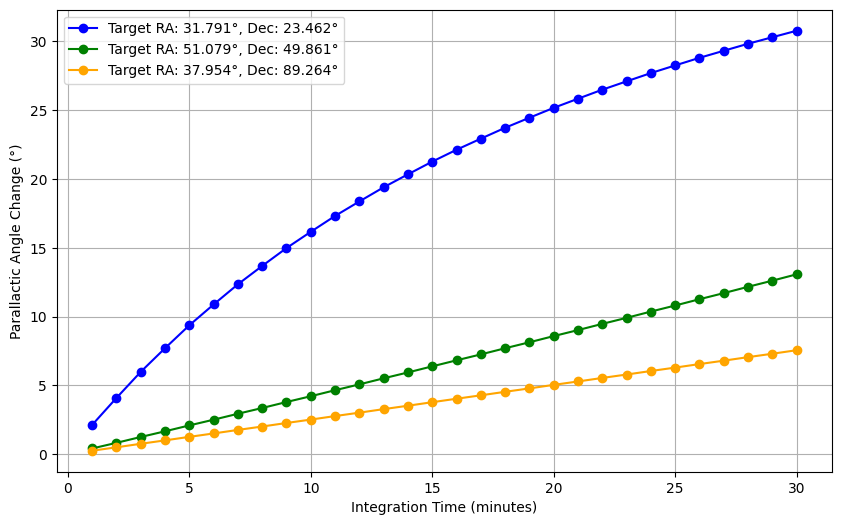

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Integration times in seconds (1 to 30 minutes in 1-minute increments)
time_intervals = np.arange(1, 31) * 60  # Convert minutes to seconds

# Colors for each target
colors = ['blue', 'green', 'orange']

# Store parallactic angle changes for each target and time interval
parallactic_angle_changes = {i: [] for i in range(len(targets))}

# Calculate parallactic angle change for each target and integration time
for target_idx, target in enumerate(targets):
    for t_int in time_intervals:
        # Calculate start parallactic angle
        pa_start = angles.calculate_parallactic_angle(
            ra=target["ra"], 
            dec=target["dec"], 
            ut=observation_time, 
            jd_str=observation_date, 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude
        )

        # Calculate the end time in UT by adding the integration time in seconds
        ut_start_hours, ut_start_minutes, ut_start_seconds = map(int, observation_time.split(":"))
        ut_start_decimal = ut_start_hours + ut_start_minutes / 60.0 + ut_start_seconds / 3600.0
        ut_end_decimal = ut_start_decimal + t_int / 3600.0
        ut_end = f"{int(ut_end_decimal // 1):02}:{int((ut_end_decimal % 1) * 60):02}:{int(((ut_end_decimal % 1) * 3600) % 60):02}"

        # Calculate end parallactic angle
        pa_end = angles.calculate_parallactic_angle(
            ra=target["ra"], 
            dec=target["dec"], 
            ut=ut_end, 
            jd_str=observation_date, 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude
        )

        # Calculate and store the absolute change in parallactic angle
        pa_change = np.abs(pa_end - pa_start)
        parallactic_angle_changes[target_idx].append(pa_change)

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    plt.plot(time_intervals / 60, parallactic_angle_changes[target_idx], '-o', color=colors[target_idx],
                label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°')

# Plot settings
plt.xlabel('Integration Time (minutes)')
plt.ylabel('Parallactic Angle Change (°)')
# plt.title("Parallactic Angle Change vs. Integration Time for Different Targets")
plt.legend()
plt.grid(True)
plt.show()


# Plotting vs paralactic angle change

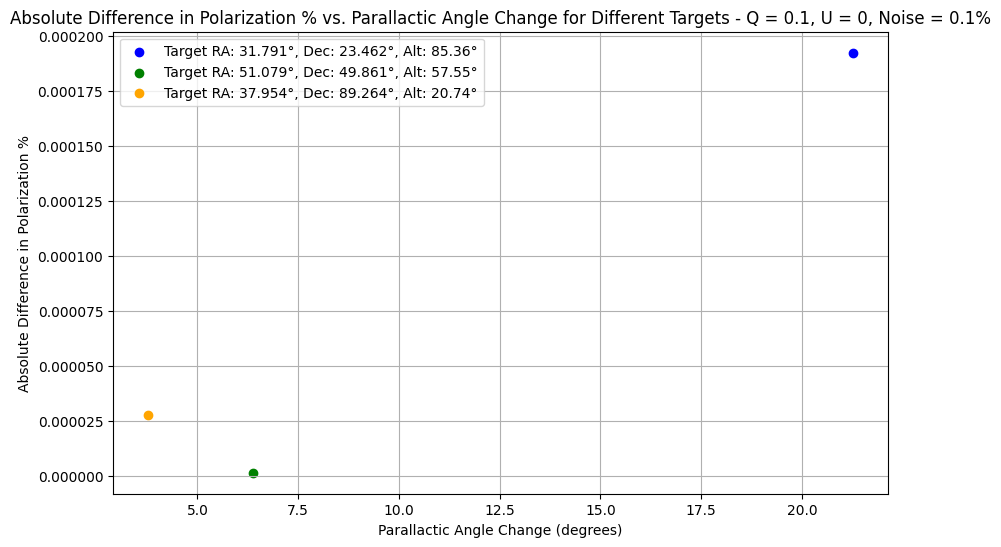

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm
import stokes

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Constant integration time (15 minutes in seconds)
t_int = 15 * 60  # 900 seconds

# Colors for each target
colors = ['blue', 'green', 'orange']

# Plot data storage
polarization_differences = {i: [] for i in range(len(targets))}
parallactic_angle_changes = {i: [] for i in range(len(targets))}

# Run the simulation for each target
for target_idx, target in enumerate(targets):
    Q_injected = 0.1  # Example injected polarization level in Stokes Q
    U_injected = 0
    noise_percentage = 0.1
    injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
    
    # Calculate start and end parallactic angles
    pa_start = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=observation_time, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )

    # Calculate the end time in UT by adding the integration time in seconds
    ut_start_hours, ut_start_minutes, ut_start_seconds = map(int, observation_time.split(":"))
    ut_start_decimal = ut_start_hours + ut_start_minutes / 60.0 + ut_start_seconds / 3600.0
    ut_end_decimal = ut_start_decimal + t_int / 3600.0
    ut_end = f"{int(ut_end_decimal // 1):02}:{int((ut_end_decimal % 1) * 60):02}:{int(((ut_end_decimal % 1) * 3600) % 60):02}"

    # Calculate the end parallactic angle
    pa_end = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=ut_end, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )

    # Calculate the change in parallactic angle
    pa_change = np.abs(pa_end - pa_start)
    parallactic_angle_changes[target_idx].append(pa_change)
    
    # Run matrix inversion function with the specified integration time
    S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
        ra=target["ra"], 
        dec=target["dec"], 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude, 
        jd_str=observation_date, 
        ut_start=observation_time, 
        t_int=t_int, 
        Q=Q_injected, 
        U=U_injected, 
        delta_HWP=0.5,
        noise_percentage=noise_percentage,
        include_V=False,
        sub_tint=1  # Sub-integration time in seconds
    )
    
    # Calculate retrieved polarization
    Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
    retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
    
    # Absolute difference in polarization percentage
    abs_diff_polarization = np.abs(injected_polarization - retrieved_polarization)
    polarization_differences[target_idx].append(abs_diff_polarization)

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    altitude = angles.calculate_altitude(
        phi=observer_latitude, 
        delta=target["dec"], 
        H=angles.calculate_hour_angle(
            ra=target["ra"], 
            observer_longitude=observer_longitude, 
            ut=observation_time, 
            jd_str=observation_date
        )
    )
    plt.scatter(parallactic_angle_changes[target_idx], polarization_differences[target_idx], color=colors[target_idx],
                label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°, Alt: {altitude:.2f}°')

# Plot settings
plt.xlabel('Parallactic Angle Change (degrees)')
plt.ylabel('Absolute Difference in Polarization %')
plt.title("Absolute Difference in Polarization % vs. Parallactic Angle Change for Different Targets - Q = " \
    + str(Q_injected) + ", U = " + str(U_injected) + ", Noise = " + str(noise_percentage) + "%")
plt.legend()
plt.grid(True)
plt.show()
